In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy.stats as stats
import seaborn as sns


# Causal graphs, identification, and models of causal exposure


Graph notation less general than potential outcome framework, but 

* thinking about causal systems
* uncover identification strategies

> It is useful to separate the inferential problem into statistical and identification components. Studies of identification seek to characterize the conclusions sthat could be drawsn if one could use the sampling process to obtain an unlimited number of observations. (Manski, 1995)

The two most crucial ingredients for an identification analysis are:

* The set of assumptions about causal relationships that the analysis is willing to assert based on theory and past research, including assumptions about relationships between variables that have not been observed but that are related both to the cause and outcome of interest.

* The pattern of informatin one can assume would be contained in the joint distribution of the variables in the observed dataset if all memebers of the population had been included in the sample that generated the dataset.

$\rightarrow$ causal graphs offer an effective and efficient representation for both

## Basic elements of causal graphs

* nodes
* edges
* paths
    * parent and child
    * decendent

<img src="material/graph_with_cycle.png" height="200" width=200 />

<img src="material/graph_shorthand_unobserved_common_cause.png" height="500" width=500 />

unconditional dependence fork and inverted fork

<img src="material/basic_causal_relationships.png" height="200" width=200 />

### Conditioning and confounding

<img src="material/confounding_variable.png" height="250" width=250 />

* $C$ is a confounding variable that affects both the dependent and independent variable.

* Conditioning is a modelig strategy that allows to determine causal effects in the presence of observed confounders.

$\rightarrow$ What happens if $C$ is unobserved?

How about an example from educational choice where we have observed and unobserved confounders?

<img src="material/fig-confounders-education.png" height=500 width=500 />

## Graphs and structural equations

Let's look at another example and assume we are interested in the effect of parental background (P), charter schools (D), and neighborhoods (N) on test scores (Y).

We could set up the following **linear** regression equations:

\begin{align*}
D & = \alpha_D + b_P P + \epsilon_D \\
Y & = \alpha_Y + b_D D + b_P P + + b_N N + \epsilon_Y
\end{align*}

<img src="material/fig-equivalent-representations-standard.png" height=500 width=500 />

<img src="material/fig-equivalent-representations-magnified.png" height=500 width=500 />

We can set up the same *nonparametric* structural equations for both representations:

\begin{align*}
P & = f_P(\epsilon_1)    \\
D & = f_D(P, \epsilon_2) \\
N & = f_N(\epsilon_3) \\
Y & = f_Y(P, D, N, \epsilon_4)
\end{align*}

## Illustration of collider variables

In [2]:
# SAT scores and individual motivation are uncorrelated in the population
SAT = np.random.normal(loc=1, scale=1, size=250)
motivation = np.random.normal(loc=1, scale=1, size=250)

# Both toghether determine college admission
score = SAT + motivation
cutoff = np.percentile(score, 85)
is_admitted = score > cutoff

# For further processing we create a data frame.
data = np.array([SAT, motivation, is_admitted]).T
columns = ['SAT', 'motivation', 'admission']
df = pd.DataFrame(data=data, columns=columns)
df.head()

,SAT,motivation,admission
0,-0.230564,1.762968,0.0
1,1.440951,2.028374,1.0
2,2.222265,0.362688,0.0
3,1.408924,2.091473,1.0
4,-0.272631,0.959449,0.0


The Pearson correlation coefficient is   0.044


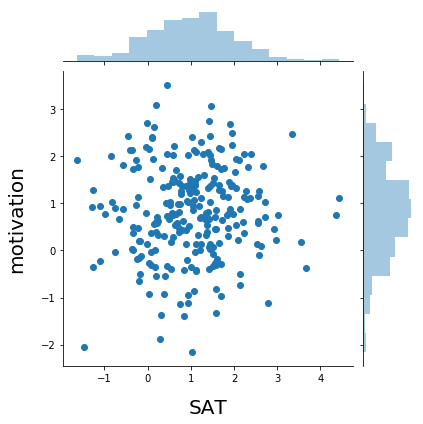

In [3]:
sns.jointplot('SAT', 'motivation', df);
print('The Pearson correlation coefficient is {:7.3f}'.format(stats.pearsonr(df['SAT'], df['motivation'])[0]))

What happens if we conidition on college admittance $C$, i.e. on a collider variable?

The Pearson correlation coefficient is  -0.719


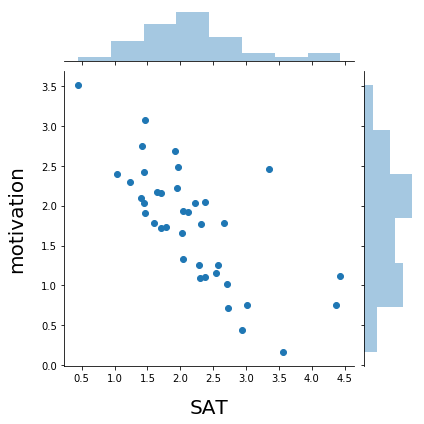

In [4]:
df_admitted = df[is_admitted]
sns.jointplot('SAT', 'motivation', df_admitted);
print('The Pearson correlation coefficient is {:7.3f}'.format(stats.pearsonr(df_admitted['SAT'], df_admitted['motivation'])[0]))

<img src="material/collider_2.png" height="200" width=200 />
<img src="material/collider.png" height="200" width=200 />
<img src="material/graph_shorthand_unobserved_common_cause.png" height="200" width=200 />
<img src="material/nonignorability.png" height="200" width=200 />
<img src="material/selection_on_unobservables.png" height="200" width=200 />
<img src="material/sufficient_conditioning.png" height="200" width=200 />
